# Train a 'DESCRIPTION' classifier

Instead of building from a MIMIC trained language model, or a Wikitext-103 model, start with blank AWD-LSTM model

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
init_model_file = base_path/'cl_head'
cycles_file = base_path/'cl_num_iterations.pickle'
enc_file = 'cl_enc'
descr_ft_file = 'cl_fine_tuned_'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
### FOR AWD_LSTM
### changing batch size affects learning rate
# batch size of 64 GPU uses about 16GB RAM (seems to work, but next run fails)
# batch size of 48 GPU uses 16GB RAM at peak
### FOR TRANSFORMER
# batch size of 48 requires more than 16GB RAM
# batch size of 32 requires more than 16GB RAM
# batch size of 4 requires about 15 GB RAM
### FOR TRANSFORMERXML
# batch size of 8 requires more than 16GB RAM
# batch size of 4 requires about 11 GB RAM
bs=4

In [4]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()
release_mem()

In [5]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


In [6]:
df = orig_df.sample(frac=pct_data_sample, random_state=seed)

In [7]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1452901,1454539,14755,151669.0,2125-02-13,2125-02-13 05:37:00,2125-02-13 05:40:00,Nursing/other,Report,19585.0,NaN,Respiratory Care:\nPatient on PSV overnight of...
462929,466766,46041,176979.0,2160-06-02,2160-06-02 02:43:00,2160-06-02 02:57:32,Nursing,Nursing Progress Note,18654.0,NaN,"Shock, cardiogenic\n Assessment:\n Hemodyn..."
227661,237449,81883,118744.0,2143-10-28,NaN,NaN,ECG,Report,NaN,NaN,Compared to tracing #1 the patient's rate has ...
597361,603087,50450,147724.0,2191-09-20,2191-09-20 23:48:00,2191-09-20 23:48:27,Physician,Physician Attending Admission Note - MICU,16383.0,NaN,Chief Complaint: GI Bleed-melena and hemateme...
973311,962711,7287,108868.0,2152-06-02,2152-06-02 23:18:00,NaN,Radiology,PELVIS PORTABLE,NaN,NaN,[**2152-6-2**] 11:18 PM\n PELVIS PORTABLE ...


In [8]:
print('Unique Categories:', len(df.CATEGORY.unique()))
print('Unique Descriptions:', len(df.DESCRIPTION.unique()))

Unique Categories: 15
Unique Descriptions: 1708


#### This is a very CPU and RAM intensive process - no GPU involved

Also, since there are a wide range of descriptions, not all descriptions present in the test set are in the validation set, so cannot learn all of them.

In [9]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
    print('loaded existing data')
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set see for repeatability
               .label_from_df(cols='DESCRIPTION')
               #building classifier to automatically determine DESCRIPTION
               .databunch(bs=bs))
    data_cl.save(filename)
    print('created new data bunch')

loaded existing data


In [15]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [11]:
learn.unfreeze()
learn.lr_find()
release_mem()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


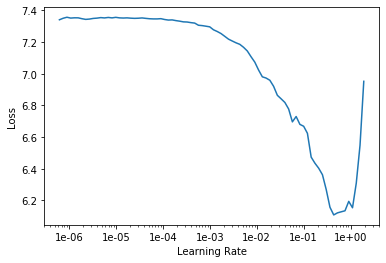

In [12]:
# Change learning rate based on results from the above plot
learn.recorder.plot()

### AWD_LSTM training

First unfrozen training with `learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))` results in 

    Total time: 22:36

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	0.967378 	0.638532 	0.870705 	22:36
        
First frozen training with `pretrained=False` and bs of 64

    Total time: 42:07

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	2.440479 	2.399600 	0.545564 	42:07
        
Unfrozen run with `learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))` and `pretrained=False` and `bs=48`

    Total time: 56:26

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	2.530828 	2.415014 	0.545564 	56:26

In [16]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
release_mem()

epoch,train_loss,valid_loss,accuracy,time
0,2.530828,2.415014,0.545564,56:26


### Try Transformer instead of AWD_LSTM

This architecture requires a very small batch size (4) to fit in GPU memory, is very slow, and has poor accuracy. Also of note is the very low training loss and corresponding very high validation loss.

    Total time: 4:02:13

    epoch 	train_loss 	valid_loss 	 accuracy 	time
        0 	2.913743 	144113.546875 	0.000024 	4:02:13
        
Perhaps I picked the wrong learning rate, or other hyper parameters?

In [10]:
learn = text_classifier_learner(data_cl, Transformer, drop_mult=0.5, pretrained=False)
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


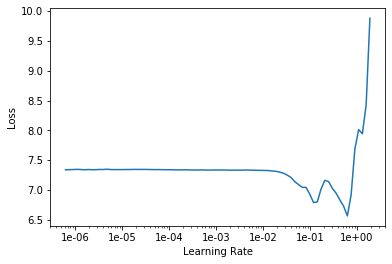

In [11]:
learn.lr_find()
learn.recorder.plot()
release_mem()

In [12]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
release_mem()

epoch,train_loss,valid_loss,accuracy,time
0,2.913743,144113.546875,0.000024,4:02:13


### Try TransformerXL

    Total time: 4:11:31

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	2.446510 	11688.685547 	0.000289 	4:11:31

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


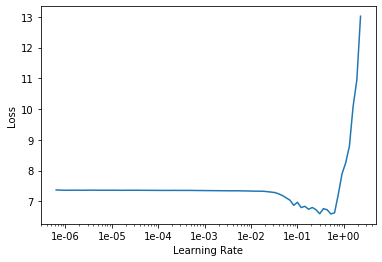

In [10]:
learn = text_classifier_learner(data_cl, TransformerXL, drop_mult=0.5, pretrained=False)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
release_mem()

In [11]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
release_mem()

epoch,train_loss,valid_loss,accuracy,time
0,2.446510,11688.685547,0.000289,4:11:31
